# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

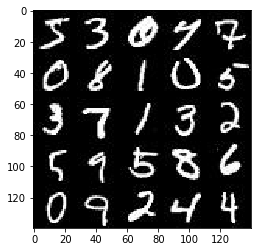

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

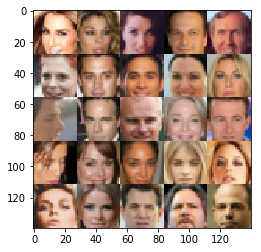

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Users\Mohammad\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    
    return (inputs, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [22]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
 
        flat = tf.reshape(relu2, (-1, 7*7*112))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        
        
        x1 = tf.layers.dense(z, 7*7*112)
        x1 = tf.reshape(x1, (-1, 7, 7, 112))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 56, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='SAME')
        
        return tf.tanh(logits)
        
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
#     alpha = 0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]


    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, learn_rate = model_inputs(data_shape[1],  data_shape[2],  data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples = []
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                print_every = 10
                show_every = 100
                show_img = 20
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % print_every == 0:

                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))


                if steps % show_every == 0:
                    show_generator_output(sess, show_img, input_z, data_shape[3], data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8171... Generator Loss: 1.2201
Epoch 1/2... Discriminator Loss: 2.1439... Generator Loss: 0.3618
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.8557
Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 2.3676
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 1.3035
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 1.1930
Epoch 1/2... Discriminator Loss: 1.8397... Generator Loss: 0.2133
Epoch 1/2... Discriminator Loss: 1.2821... Generator Loss: 1.4772
Epoch 1/2... Discriminator Loss: 1.4749... Generator Loss: 1.9478
Epoch 1/2... Discriminator Loss: 1.8884... Generator Loss: 0.2167


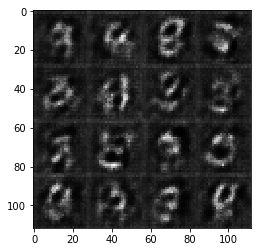

Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 0.6325
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 0.8509
Epoch 1/2... Discriminator Loss: 1.6583... Generator Loss: 1.7189
Epoch 1/2... Discriminator Loss: 1.3060... Generator Loss: 0.5346
Epoch 1/2... Discriminator Loss: 1.4800... Generator Loss: 1.5572
Epoch 1/2... Discriminator Loss: 1.2080... Generator Loss: 0.9731
Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.6007
Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 0.5903
Epoch 1/2... Discriminator Loss: 1.0391... Generator Loss: 0.7031
Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 1.1805


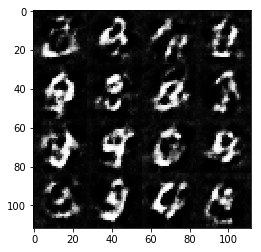

Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 0.8319
Epoch 1/2... Discriminator Loss: 1.0523... Generator Loss: 1.0276
Epoch 1/2... Discriminator Loss: 1.2719... Generator Loss: 1.8122
Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 0.4849
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 0.5537
Epoch 1/2... Discriminator Loss: 0.9214... Generator Loss: 1.2465
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 0.6490
Epoch 1/2... Discriminator Loss: 1.1300... Generator Loss: 0.6372
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 1.0055... Generator Loss: 0.6401


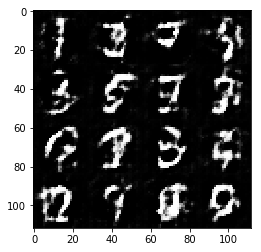

Epoch 1/2... Discriminator Loss: 0.8386... Generator Loss: 1.1958
Epoch 1/2... Discriminator Loss: 1.1505... Generator Loss: 0.6064
Epoch 1/2... Discriminator Loss: 0.8946... Generator Loss: 1.5452
Epoch 1/2... Discriminator Loss: 1.6150... Generator Loss: 0.2817
Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 1.3552
Epoch 1/2... Discriminator Loss: 0.8676... Generator Loss: 0.9272
Epoch 1/2... Discriminator Loss: 0.7711... Generator Loss: 1.1637
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 0.8382
Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 1.5394
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.4216


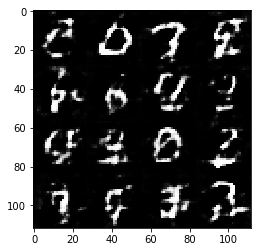

Epoch 1/2... Discriminator Loss: 0.7152... Generator Loss: 1.1149
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 1.5971
Epoch 1/2... Discriminator Loss: 1.1602... Generator Loss: 1.6547
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 0.4417
Epoch 1/2... Discriminator Loss: 0.8231... Generator Loss: 1.8149
Epoch 1/2... Discriminator Loss: 1.1233... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 1.4202
Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 1.2647
Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 1.1064
Epoch 1/2... Discriminator Loss: 1.1295... Generator Loss: 1.5398


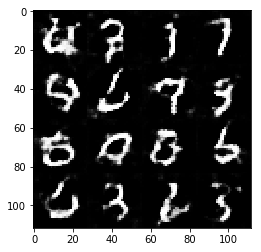

Epoch 1/2... Discriminator Loss: 1.4215... Generator Loss: 1.7065
Epoch 1/2... Discriminator Loss: 1.0640... Generator Loss: 1.0050
Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 0.7387
Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 0.7640
Epoch 1/2... Discriminator Loss: 2.8376... Generator Loss: 0.0875
Epoch 1/2... Discriminator Loss: 1.6862... Generator Loss: 0.3439
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.4605
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 0.8885
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.4888


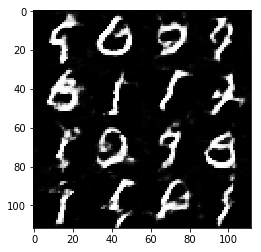

Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 1.1697
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 0.6579
Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 0.7829
Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.6065... Generator Loss: 0.2988
Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 1.1561
Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 0.7072
Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 1.0077
Epoch 1/2... Discriminator Loss: 1.0327... Generator Loss: 1.0416


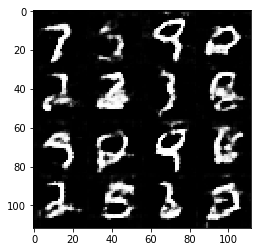

Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 0.7400
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 0.6661
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 1.0688
Epoch 1/2... Discriminator Loss: 0.8748... Generator Loss: 1.3316
Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 1.7992
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 0.9497
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 1.1986
Epoch 1/2... Discriminator Loss: 1.1672... Generator Loss: 0.6793
Epoch 1/2... Discriminator Loss: 1.4537... Generator Loss: 0.3780
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 1.2808


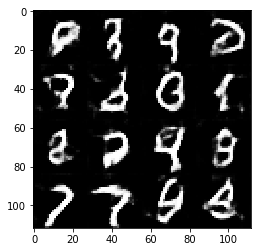

Epoch 1/2... Discriminator Loss: 0.9576... Generator Loss: 0.8812
Epoch 1/2... Discriminator Loss: 1.4102... Generator Loss: 0.4133
Epoch 1/2... Discriminator Loss: 0.6876... Generator Loss: 1.3609
Epoch 1/2... Discriminator Loss: 0.7945... Generator Loss: 1.4068
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.8204
Epoch 1/2... Discriminator Loss: 3.5247... Generator Loss: 0.0690
Epoch 1/2... Discriminator Loss: 1.4350... Generator Loss: 0.9690
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 1.0803
Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 1.2988
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.5153


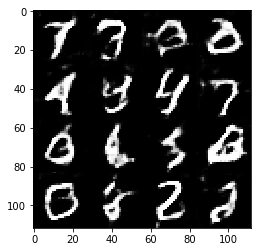

Epoch 1/2... Discriminator Loss: 1.4572... Generator Loss: 0.3544
Epoch 1/2... Discriminator Loss: 0.9004... Generator Loss: 1.0255
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 0.9012
Epoch 2/2... Discriminator Loss: 0.8441... Generator Loss: 1.0301
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 0.6950
Epoch 2/2... Discriminator Loss: 0.8708... Generator Loss: 0.9119
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 0.6102
Epoch 2/2... Discriminator Loss: 1.2962... Generator Loss: 0.5036
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 1.0478


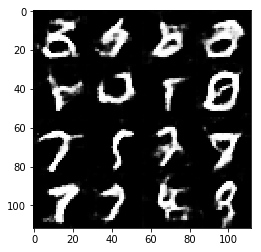

Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 1.1690
Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 1.3365
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.1892
Epoch 2/2... Discriminator Loss: 1.3745... Generator Loss: 0.3847
Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 0.8837
Epoch 2/2... Discriminator Loss: 1.0352... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 0.9852... Generator Loss: 0.6750
Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 1.0120
Epoch 2/2... Discriminator Loss: 1.0250... Generator Loss: 1.2813
Epoch 2/2... Discriminator Loss: 1.4414... Generator Loss: 0.3941


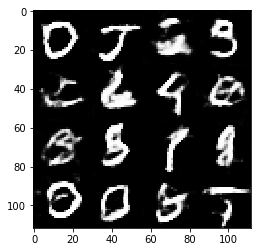

Epoch 2/2... Discriminator Loss: 0.7435... Generator Loss: 1.0388
Epoch 2/2... Discriminator Loss: 0.7891... Generator Loss: 1.1615
Epoch 2/2... Discriminator Loss: 0.7679... Generator Loss: 1.0137
Epoch 2/2... Discriminator Loss: 0.9580... Generator Loss: 1.3776
Epoch 2/2... Discriminator Loss: 1.0785... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.5393... Generator Loss: 1.1835
Epoch 2/2... Discriminator Loss: 1.1739... Generator Loss: 0.9216
Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 0.8522
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.1734
Epoch 2/2... Discriminator Loss: 0.7431... Generator Loss: 1.1570


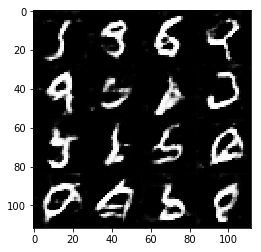

Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 1.0385
Epoch 2/2... Discriminator Loss: 1.0876... Generator Loss: 1.8303
Epoch 2/2... Discriminator Loss: 0.9097... Generator Loss: 0.9344
Epoch 2/2... Discriminator Loss: 1.2432... Generator Loss: 1.9037
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 1.4152
Epoch 2/2... Discriminator Loss: 1.0344... Generator Loss: 0.6987
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.8780
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 1.5387
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 1.4528


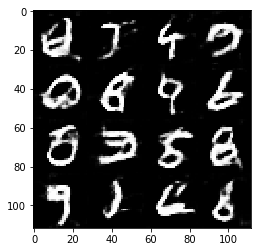

Epoch 2/2... Discriminator Loss: 0.8180... Generator Loss: 1.0802
Epoch 2/2... Discriminator Loss: 1.0997... Generator Loss: 1.4720
Epoch 2/2... Discriminator Loss: 1.1557... Generator Loss: 0.4930
Epoch 2/2... Discriminator Loss: 1.4527... Generator Loss: 0.4168
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 0.4744
Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 1.3272
Epoch 2/2... Discriminator Loss: 0.7077... Generator Loss: 1.0748
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 0.7208
Epoch 2/2... Discriminator Loss: 1.5845... Generator Loss: 0.3367


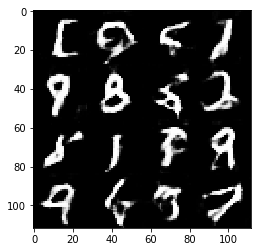

Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 0.6839
Epoch 2/2... Discriminator Loss: 1.1839... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 1.0474... Generator Loss: 0.8876
Epoch 2/2... Discriminator Loss: 0.7430... Generator Loss: 1.3478
Epoch 2/2... Discriminator Loss: 0.8567... Generator Loss: 1.1197
Epoch 2/2... Discriminator Loss: 0.9972... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 0.8825
Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 0.5778
Epoch 2/2... Discriminator Loss: 0.9844... Generator Loss: 1.1728
Epoch 2/2... Discriminator Loss: 0.7014... Generator Loss: 1.2186


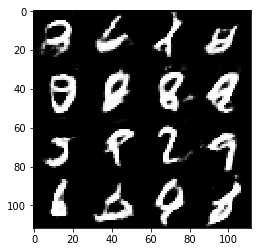

Epoch 2/2... Discriminator Loss: 1.0368... Generator Loss: 0.6343
Epoch 2/2... Discriminator Loss: 0.7270... Generator Loss: 1.1504
Epoch 2/2... Discriminator Loss: 0.6748... Generator Loss: 1.0447
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 0.7454
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.4613
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 1.6373
Epoch 2/2... Discriminator Loss: 1.0577... Generator Loss: 0.7324
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 0.5122
Epoch 2/2... Discriminator Loss: 1.0273... Generator Loss: 0.9660
Epoch 2/2... Discriminator Loss: 0.8945... Generator Loss: 0.8160


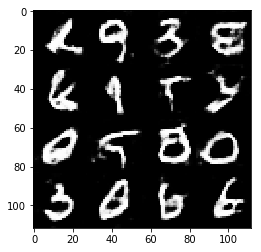

Epoch 2/2... Discriminator Loss: 0.9197... Generator Loss: 1.2887
Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 1.2729
Epoch 2/2... Discriminator Loss: 0.9289... Generator Loss: 0.9094
Epoch 2/2... Discriminator Loss: 0.7793... Generator Loss: 1.0920
Epoch 2/2... Discriminator Loss: 0.8352... Generator Loss: 0.8718
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 0.8905
Epoch 2/2... Discriminator Loss: 0.8029... Generator Loss: 1.0194
Epoch 2/2... Discriminator Loss: 0.9176... Generator Loss: 1.8793
Epoch 2/2... Discriminator Loss: 0.9170... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 0.7622


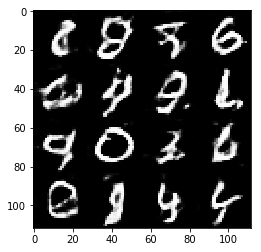

Epoch 2/2... Discriminator Loss: 1.7038... Generator Loss: 0.2726
Epoch 2/2... Discriminator Loss: 1.4585... Generator Loss: 0.4315
Epoch 2/2... Discriminator Loss: 0.8807... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 0.9100... Generator Loss: 0.8374
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 2.1564
Epoch 2/2... Discriminator Loss: 0.7729... Generator Loss: 1.0954
Epoch 2/2... Discriminator Loss: 0.7367... Generator Loss: 1.1990
Epoch 2/2... Discriminator Loss: 3.0901... Generator Loss: 0.1451
Epoch 2/2... Discriminator Loss: 0.6361... Generator Loss: 1.5173
Epoch 2/2... Discriminator Loss: 1.4508... Generator Loss: 0.4615


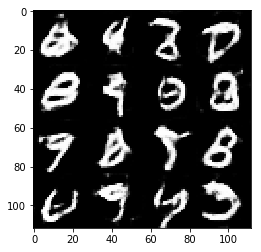

Epoch 2/2... Discriminator Loss: 1.2535... Generator Loss: 0.5121
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 0.6974
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 0.8513
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 0.9798
Epoch 2/2... Discriminator Loss: 2.1701... Generator Loss: 1.9313
Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 1.0819
Epoch 2/2... Discriminator Loss: 0.8687... Generator Loss: 0.9535


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 1.4690
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 1.6603
Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 1.8383
Epoch 1/1... Discriminator Loss: 0.2832... Generator Loss: 2.0134
Epoch 1/1... Discriminator Loss: 0.2959... Generator Loss: 2.0359
Epoch 1/1... Discriminator Loss: 0.2911... Generator Loss: 1.9534


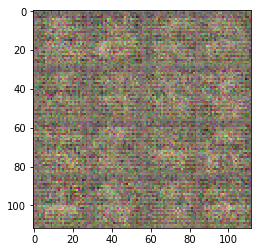

Epoch 1/1... Discriminator Loss: 0.3234... Generator Loss: 1.9870
Epoch 1/1... Discriminator Loss: 0.3270... Generator Loss: 1.9493
Epoch 1/1... Discriminator Loss: 0.3492... Generator Loss: 1.8439
Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 1.9549
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 1.9112
Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 1.9284
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 2.3881
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 1.7290
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.3690
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.5595


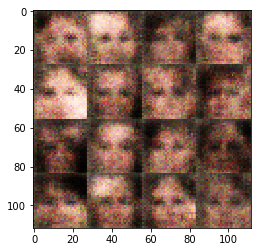

Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.4829
Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 1.7720
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 1.6616
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 1.9277
Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 0.5840... Generator Loss: 1.8109
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 1.5991
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 1.4622


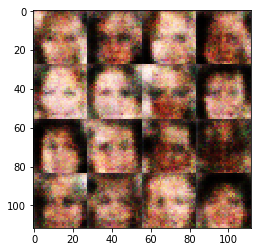

Epoch 1/1... Discriminator Loss: 0.6669... Generator Loss: 1.2830
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.3989
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.3040
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.3585
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 0.9796


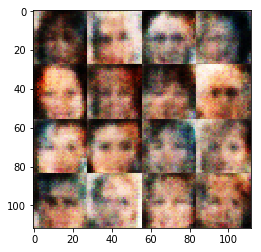

Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.2193
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.1545
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 1.0907


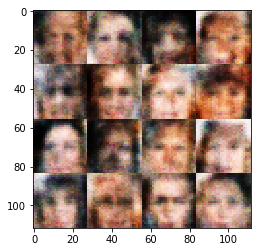

Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.5157
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.0197


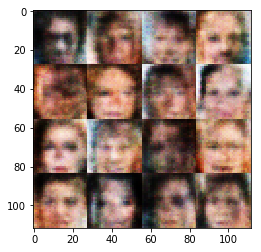

Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.2737
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 1.2217
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 1.1935


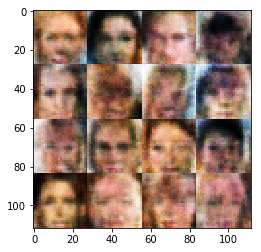

Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.3098
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.3049
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.1011
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 1.2926
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.9022


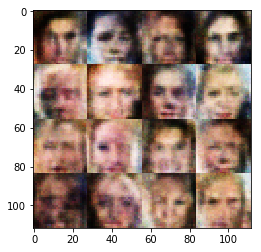

Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.6959


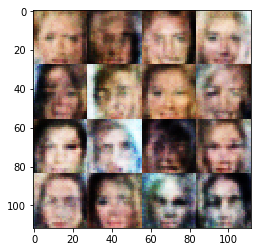

Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.2898
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 1.1105
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.4787
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 0.9231


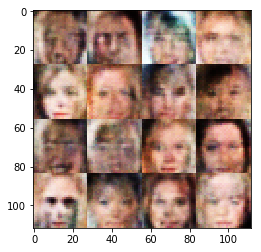

Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.5723
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 1.1830
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.5720


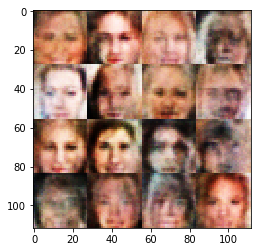

Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.3364
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.0340


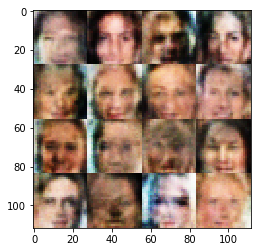

Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.2858
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.9643


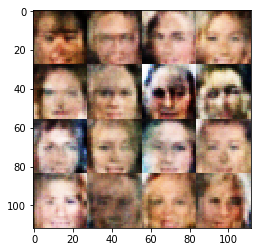

Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.8830


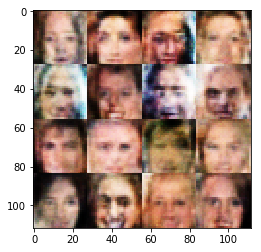

Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.8534


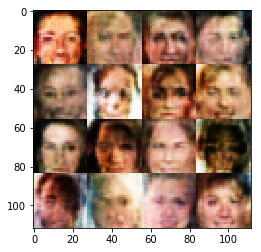

Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.9744


In [29]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.